## Plots documenting the region

In [1]:
import numpy as np
import gsw
import xarray as xr
import pandas as pd
import os

from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean as cmocean
import matplotlib

from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

%matplotlib inline

In [2]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data/data/'

In [4]:
# Climatology data
Tclim = xr.open_dataset(data_dir + "raw/climatology/RG_ArgoClim_Temperature_2017.nc", decode_times=False)
Sclim = xr.open_dataset(data_dir + "raw/climatology/RG_ArgoClim_Salinity_2017.nc", decode_times=False)

In [5]:
Climextra = xr.open_mfdataset(data_dir+ 'raw/climatology/RG_ArgoClim_201*', decode_times=False)

In [6]:
RG_clim = xr.merge([Tclim, Sclim, Climextra])

In [7]:
# Calendar type was missing, and giving errors in decoding time
RG_clim.TIME.attrs['calendar'] = '360_day'
RG_clim = xr.decode_cf(RG_clim);

In [8]:
## Add density and other things 
SA = xr.apply_ufunc(gsw.SA_from_SP, RG_clim.ARGO_SALINITY_MEAN+RG_clim.ARGO_SALINITY_ANOMALY, RG_clim.PRESSURE , 
                                    RG_clim.LONGITUDE, RG_clim.LATITUDE,
                    dask='parallelized', output_dtypes=[float,]).rename('SA')
CT = xr.apply_ufunc(gsw.CT_from_t, SA, RG_clim.ARGO_TEMPERATURE_MEAN+RG_clim.ARGO_TEMPERATURE_ANOMALY, RG_clim.PRESSURE, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')
SIGMA0 = xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,]).rename('SIGMA0')


In [9]:
RG_clim = xr.merge([RG_clim, SA, CT, SIGMA0])

In [10]:
CT_region = RG_clim.CT.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-60,-45), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()
SA_region = RG_clim.SA.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-60,-45), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()
rho_region = RG_clim.SIGMA0.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-60,-45), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()

In [11]:
Clim_region = xr.merge([CT_region, SA_region, rho_region])

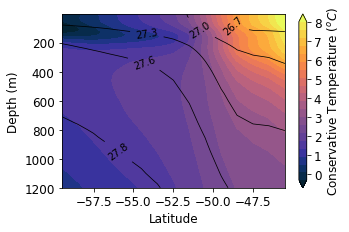

In [12]:
plt.figure(figsize=(5,3.2))
im = CT_region.mean(['month']).plot.contourf(levels=np.linspace(-0.3,8,21), cmap=cmocean.cm.thermal,
                                            add_colorbar=False
                                            )                                             

cbar = plt.colorbar(im, ticks= [0, 1,2,3,4,5,6,7, 8])
cbar.ax.set_ylabel('Conservative Temperature ($^oC$)')
plt.gca().invert_yaxis()
CS = rho_region.mean(['month']).plot.contour(levels=[26.7, 27,27.3, 27.6, 27.8], linewidths=.75,
                                       colors='k')
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels] 
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)
plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('Latitude')
plt.title('')
plt.savefig('CT.pdf')

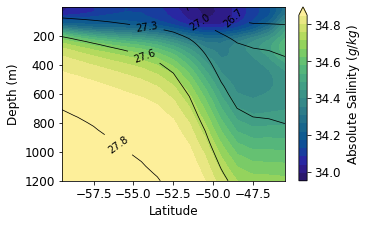

In [42]:
plt.figure(figsize=(5,3.2))
im = SA_region.mean(['month']).plot.contourf(levels=np.linspace(33.95,34.85,21),
                                        cmap=cmocean.cm.haline,
                                       add_colorbar=False)

cbar = plt.colorbar(im, ticks= [34, 34.2, 34.4, 34.6, 34.8])
cbar.ax.set_ylabel('Absolute Salinity ($g /kg$)')
plt.gca().invert_yaxis()
CS = rho_region.mean(['month']).plot.contour(levels=[26.7, 27,27.3, 27.6, 27.8], linewidths=.75,
                                       colors='k')
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels] 
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)
plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('Latitude')
plt.title('')
plt.savefig('SA.pdf')

In [14]:
# make a gridded density (Sigma0) for  plotting on TS plots
Tpts = np.linspace(-3, 20, 40)
Spts = np.linspace(33.5, 36, 41)
[Tg, Sg] = np.meshgrid(Tpts, Spts)
rhoTS = gsw.sigma0(Sg, Tg)

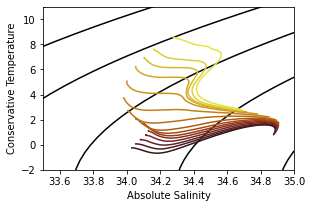

In [15]:
plt.figure(figsize=(4.5,3))
plt.contour(Sg, Tg, rhoTS, levels=10, colors="k")

for i in range(0, len(SA_region.LATITUDE)):
    plt.plot( SA_region.isel(LATITUDE=i).mean('month'), 
             CT_region.isel(LATITUDE=i).mean('month'),
            color=cmocean.cm.solar(i / len(SA_region.LATITUDE)),)
    
plt.xlim([33.5, 35.])
plt.ylim([-2, 11])
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.savefig('TS.pdf')

In [14]:
Clim_region = generate_grid_ds(Clim_region, 
        {'Z':'PRESSURE',  'Y':'LATITUDE'})
grid = Grid(Clim_region, periodic='X')

In [15]:
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   PRESSURE --> left
  * left     PRESSURE_left --> center
Y Axis (not periodic, boundary=None):
  * center   LATITUDE --> left
  * left     LATITUDE_left --> center

In [24]:
Clim_region

<xarray.Dataset>
Dimensions:        (LATITUDE: 15, LATITUDE_left: 15, PRESSURE: 48, PRESSURE_left: 48, month: 12)
Coordinates:
    LONGITUDE      float32 30.5
  * LATITUDE       (LATITUDE) float32 -59.5 -58.5 -57.5 ... -47.5 -46.5 -45.5
  * PRESSURE       (PRESSURE) float32 2.5 10.0 20.0 ... 1100.0 1150.0 1200.0
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * PRESSURE_left  (PRESSURE_left) float32 -1.25 6.25 15.0 ... 1125.0 1175.0
  * LATITUDE_left  (LATITUDE_left) float32 -60.0 -59.0 -58.0 ... -47.0 -46.0
Data variables:
    CT             (PRESSURE, LATITUDE, month) float64 0.8308 1.471 ... 2.818
    SA             (PRESSURE, LATITUDE, month) float64 33.88 33.93 ... 34.68
    SIGMA0         (PRESSURE, LATITUDE, month) float64 27.02 27.02 ... 27.52

In [16]:
g = 9.81
rho0 = 1000

N2_clim_monthly = grid.interp(-g/rho0* grid.diff(Clim_region.SIGMA0, 'Z', boundary='extend') / -(
    grid.diff(Clim_region.PRESSURE, 'Z', boundary='extend')), 'Z', boundary='extend')

In [17]:
delta_dens = Clim_region.SIGMA0 - Clim_region.SIGMA0.isel(PRESSURE=0)

In [18]:
temp = delta_dens.where(delta_dens>=0.03)
MLD = temp.PRESSURE.where(temp == temp.min('PRESSURE')).min('PRESSURE')

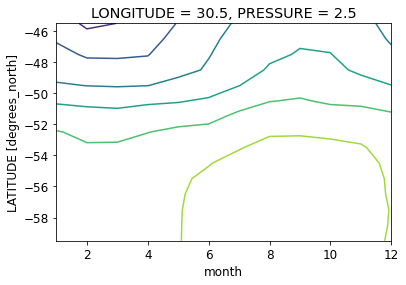

In [26]:
Clim_region.SIGMA0.isel(PRESSURE=0).plot.contour()

In [19]:
N2_mean = np.zeros((15,12))
    
for i in range(0,12):
    for j in range(0, len(N2_clim_monthly.LATITUDE)):
        N2_mean[j,i] = N2_clim_monthly[:,j,i].sel(PRESSURE=slice(MLD[j,i],MLD[j,i]+100)
                                          ).mean('PRESSURE')
        
#N2_mean = xr.DataArray(N2_mean, coords = {N2_clim_monthly)

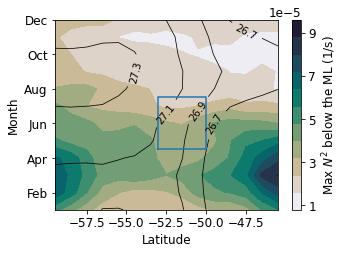

In [47]:
fig, ax = plt.subplots(figsize=(5,3.5))
im = N2_clim_monthly.max('PRESSURE').plot.contourf(ax=ax, y='month',levels=13, 
                                              cmap=cmocean.cm.rain,
                                                  add_colorbar=False)
cbar = plt.colorbar(im, ticks=np.linspace(1,9, 5)*1e-5)
cbar.ax.set_ylabel('Max $N^2$ below the ML (1/s)')
CS = Clim_region.SIGMA0.isel(PRESSURE=0).T.plot.contour(levels=[26.7, 26.9, 27.1, 27.3],
                                                  linewidths=.75,
                                                  colors='k')
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels] 
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

plt.plot([-53,-53,-50,-50,-53], [4.5,7.5,7.5,4.5,4.5])
plt.title('')
ax.set_yticks([2,4,6,8,10,12])
ax.set_yticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])
ax.set_ylabel('Month')
ax.set_xlabel('Latitude')
plt.savefig('N2base.pdf')

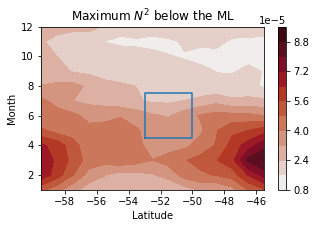

In [34]:
plt.figure(figsize=(5,3))
N2_clim_monthly.max('PRESSURE').plot.contourf(y='month',levels=13, 
                                              cmap=cmocean.cm.amp, a)
plt.plot([-53,-53,-50,-50,-53], [4.5,7.5,7.5,4.5,4.5])
plt.title('Maximum $N^2$ below the ML [1/s]')
plt.ylabel('Month')
plt.xlabel('Latitude')
plt.savefig('N2base.pdf')

Text(0.5, 0, 'Latitude')

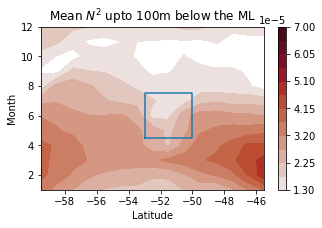

In [33]:
plt.figure(figsize=(5,3))
plt.contourf(N2_clim_monthly.LATITUDE,N2_clim_monthly.month,
         N2_mean.T, levels=np.linspace(1.3, 7,13)*1e-5, cmap=cmocean.cm.amp)
plt.plot([-53,-53,-50,-50,-53], [4.5,7.5,7.5,4.5,4.5])
plt.title('Mean $N^2$ upto 100m below the ML')
plt.colorbar()
plt.ylabel('Month')
plt.xlabel('Latitude')
#plt.savefig('N2base.pdf')

In [35]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [36]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [37]:
ds_659

<xarray.Dataset>
Dimensions:      (ctd_data_point: 1363330)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 nan nan nan nan ... 1.165 1.037 nan
    latitude     (ctd_data_point) float64 -51.51 -51.51 -51.51 ... -51.7 -51.7
    longitude    (ctd_data_point) float64 30.03 30.03 30.03 ... 38.99 38.99
    temperature  (ctd_data_point) float64 3.564 3.561 3.56 ... 1.812 1.811 1.814
    salinity     (ctd_data_point) float64 nan nan nan nan ... 33.89 33.89 nan
    dives        (ctd_data_point) float64 1.0 1.0 1.0 1.0 ... 462.5 462.5 462.5
    time         (ctd_data_point) datetime64[ns] 2019-04-30T13:20:51.23000345...

In [38]:
ds_659['SA'] = xr.apply_ufunc(gsw.SA_from_SP, ds_659.salinity, ds_659.pressure , 
                                    ds_659.longitude, ds_659.latitude,
                    dask='parallelized', output_dtypes=[float,]).rename('SA')

In [39]:
ds_659['CT'] = xr.apply_ufunc(gsw.CT_from_t, ds_659['SA'],ds_659.temperature, 
                              ds_659.pressure, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')

In [40]:
ds_660['SA'] = xr.apply_ufunc(gsw.SA_from_SP, ds_660.salinity, ds_660.pressure , 
                                    ds_660.longitude, ds_660.latitude,
                    dask='parallelized', output_dtypes=[float,]).rename('SA')

ds_660['CT'] = xr.apply_ufunc(gsw.CT_from_t, ds_660['SA'],ds_660.temperature, 
                              ds_660.pressure, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')

In [41]:
from xhistogram.xarray import histogram

In [42]:
Tmerged = xr.concat([ds_659.CT, ds_660.CT], dim='ctd_data_point')
Smerged = xr.concat([ds_659.SA, ds_660.SA], dim='ctd_data_point')

In [43]:
Tmerged

<xarray.DataArray 'CT' (ctd_data_point: 2717462)>
array([nan, nan, nan, ..., nan, nan, nan])
Dimensions without coordinates: ctd_data_point

In [44]:
binsT = np.linspace(-1,4,151)
binsS = np.linspace(33.5, 35,151)

In [47]:
hTS = histogram(Tmerged, 
         Smerged, 
         bins =[binsT, binsS])

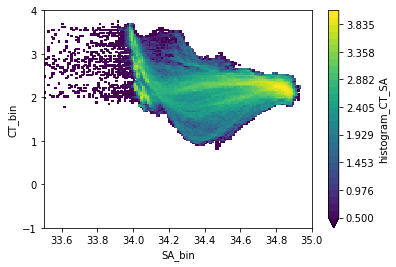

In [48]:
np.log10(hTS).plot(levels=31, vmin=0.5)

In [61]:
# make a gridded density (Sigma0) for  plotting on TS plots
Tpts = np.arange(-3, 20, 0.02)
Spts = np.arange(33.5, 36, 0.01)
[Tg, Sg] = np.meshgrid(Tpts, Spts)
rhoTS = gsw.sigma0(Sg, Tg)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


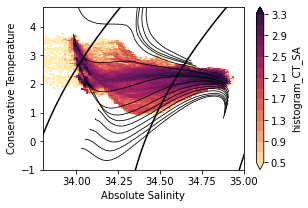

In [74]:
plt.figure(figsize=(4.5,3))
plt.contour(Sg, Tg, rhoTS, levels=10, colors="k")

for i in range(0, len(SA_region.LATITUDE)):
    plt.plot( SA_region.isel(LATITUDE=i).mean('month'), 
             CT_region.isel(LATITUDE=i).mean('month'),color='k'
            #color=cmocean.cm.solar(i / len(SA_region.LATITUDE))
             ,linewidth=0.8)
np.log10(hTS).plot(levels=15, vmin=0.5, vmax=3.3, cmap=cmocean.cm.matter)
plt.xlim([33.8, 35.])
plt.ylim([-1, 4.7])
plt.xlabel('Absolute Salinity')
plt.ylabel('Conservative Temperature')
plt.savefig('TS.pdf')